In [1]:
import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.device_count() > 0 else "No GPU detected")


Torch version: 2.5.0
CUDA available: True
CUDA version: 11.8
Number of GPUs: 1
GPU name: NVIDIA GeForce RTX 4090


## Network Model

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # Output channels: 16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # Output channels: 32
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Output channels: 64
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # Output channels: 64
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # Output channels: 64
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # Output channels: 64
        self.conv7 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # Output channels: 64
        self.conv8 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Output channels: 128
        self.conv9 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # Output channels: 256
        self.fc0 = nn.Linear(64, 64)    # the FCL for x1
        self.fc1 = nn.Linear(2*2*256, 64)  # Fully connected layer
        self.fc2 = nn.Linear(64, 3)         # Output layer

        # Define trainable tensors
        self.Wk = nn.Parameter(torch.randn(64, 4, 4) * 0.001)   # Tensor for custom computation
        self.Vk = nn.Parameter(torch.randn(64, 4) * 0.001)      # Tensor for custom computation

    def forward(self, x, x1):
        # Reshape x to 4D and print initial size
        x = x.view(-1, 1, 64, 64)  # Reshape x to [batch_size, 1, 64, 64]
        # print("Initial size of x:", x.size()) # Should be [batch_size, 1, 64, 64]

        # Handling custom operations
        DT_Wk_D = torch.einsum('bi,kij,bj->bk', x1, self.Wk, x1) + torch.einsum('ij,bj->bi', self.Vk, x1) # [batch_size, 64]
        DT_Wk_D = self.fc0(DT_Wk_D).unsqueeze(2).unsqueeze(3).expand(-1, -1, 8, 8) # [batch_size, 64, 8, 8]

        # First convolution and pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)#[batch_size, 16, 32, 32]

        # Second convolution and pooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)#  [batch_size, 32, 16, 16]

        # Third convolution and pooling
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2) #  [batch_size, 64, 8, 8]
        
        # x = torch.cat((x, DT_Wk_D), dim=1)
        x = x + DT_Wk_D

        # Additional convolutions without pooling
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv9(x))
        x = F.max_pool2d(x, 2) #[batch_size, 256, 2, 2]

        # Flatten for FC layers
        x = torch.flatten(x, 1) # [batch_size, 1024]

        # Continue with the final layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # [batch_size, 1]

        return x

model = CustomModel()
optimizer = Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()  # Assuming MSE loss as in TensorFlow

## Data handling

In [3]:
import h5py
import numpy as np

# Adjust file paths and set up the dataset and data loader
file_path = r"C:\Users\evod\work\ai13\pytorch\data\train_test_split.h5"
with h5py.File(file_path, "r") as f:
    neff_train = np.array(f['neff_train'])
    weight_train = np.array(f['weight_train'])
    params_train = np.array(f['params_train'])
    pattern_train = np.array(f['pattern_train'])
    
    neff_test = np.array(f['neff_test'])
    weight_test = np.array(f['weight_test'])
    params_test = np.array(f['params_test'])
    pattern_test = np.array(f['pattern_test'])



In [ ]:
print("hello world")

In [4]:
# process the data, remove all modes with n_eff=0
from tqdm import tqdm

# Result arrays initialized with zeros or some invalid value
modified_neff_train = np.zeros_like(neff_train)
modified_weight_train = np.zeros_like(weight_train)

modified_neff_test = np.zeros_like(neff_test)
modified_weight_test = np.zeros_like(weight_test)

for i in tqdm(range(neff_train.shape[0]), desc="Processing Training Data Rows"):
    # Filter out zeros and get the remaining valid entries
    valid_indices = neff_train[i] != 0
    valid_values_neff = neff_train[i][valid_indices]
    valid_values_weight = weight_train[i][valid_indices]

    # Place valid entries at the start of the row in the result arrays
    modified_neff_train[i, :len(valid_values_neff)] = valid_values_neff
    modified_weight_train[i, :len(valid_values_weight)] = valid_values_weight

for i in tqdm(range(neff_test.shape[0]), desc="Processing Test Data Rows"):
    # Filter out zeros and get the remaining valid entries
    valid_indices = neff_test[i] != 0
    valid_values_neff = neff_test[i][valid_indices]
    valid_values_weight = weight_test[i][valid_indices]

    # Place valid entries at the start of the row in the result arrays
    modified_neff_test[i, :len(valid_values_neff)] = valid_values_neff
    modified_weight_test[i, :len(valid_values_weight)] = valid_values_weight

Processing Test Data Rows: 100%|███████████████████████████████████████████| 477427/477427 [00:01<00:00, 239751.78it/s]


In [5]:
# dataframe to matrix
xs = pattern_train.reshape([-1,64*64])
x1s = params_train
ys = modified_neff_train[:,0:3]

xs1 = pattern_test.reshape([-1,64*64])
x1s1 = params_test
ys1 = modified_neff_test[:,0:3]


batch_size = 256
n_batch = neff_train.shape[0]//batch_size
n_batch1 = neff_test.shape[0]//batch_size
# testbatch_size = data_test.shape[0]//n_batch

# Convert and cache tensors before training starts
xs = torch.tensor(xs, dtype=torch.float32)
x1s = torch.tensor(x1s, dtype=torch.float32)
ys = torch.tensor(ys, dtype=torch.float32)

xs1 = torch.tensor(xs1, dtype=torch.float32)
x1s1 = torch.tensor(x1s1, dtype=torch.float32)
ys1 = torch.tensor(ys1, dtype=torch.float32)

## Training loop

In [6]:
import torch
import torch.optim as optim
from torch.autograd import Variable

# Assuming your model is defined as `model`
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()  # Adjust this if your loss is different

# Enable GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Main training loop
for i in range(10000):
    train_losses=[] 
    test_losses=[]

    model.train()
    for batch in range(n_batch):
        
        batch_xs = xs[batch*batch_size:(batch+1)*batch_size,:]
        batch_x1s = x1s[batch*batch_size:(batch+1)*batch_size,:]
        batch_ys = ys[batch*batch_size:(batch+1)*batch_size,:]
        
        optimizer.zero_grad()
        outputs = model(batch_xs.to(device), batch_x1s.to(device))  # Adjust if your model takes two inputs differently
        loss = criterion(outputs, batch_ys.to(device))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    for batch in range(n_batch1):
        
        batch_xs1 = xs1[batch*batch_size:(batch+1)*batch_size,:]
        batch_x1s1 = x1s1[batch*batch_size:(batch+1)*batch_size,:]
        batch_ys1 = ys1[batch*batch_size:(batch+1)*batch_size,:]
        
        outputs = model(batch_xs1.to(device), batch_x1s1.to(device))  # Adjust if your model takes two inputs differently
        loss = criterion(outputs, batch_ys1.to(device))
        test_losses.append(loss.item())
    
    print(f"After {i} iteration,")
    print(f"Training loss: {np.mean(train_losses)}, Test loss: {np.mean(test_losses)}")

After 0 iteration,
Training loss: 0.7350999842434471, Test loss: 0.4166229708048279
After 1 iteration,
Training loss: 0.36400630126956196, Test loss: 0.36023694179280635
After 2 iteration,
Training loss: 0.33161599094690714, Test loss: 0.33162613176289035
After 3 iteration,
Training loss: 0.3140399595172453, Test loss: 0.31190491859429387
After 4 iteration,
Training loss: 0.3013771783994604, Test loss: 0.3006557451097431
After 5 iteration,
Training loss: 0.29193475038169364, Test loss: 0.29059055716982474
After 6 iteration,
Training loss: 0.284574591678207, Test loss: 0.28016330680286294
After 7 iteration,
Training loss: 0.2783193216464131, Test loss: 0.2740360884667402
After 8 iteration,
Training loss: 0.27295321258484045, Test loss: 0.2682917704485964
After 9 iteration,
Training loss: 0.26838999491084775, Test loss: 0.26383788868896824
After 10 iteration,
Training loss: 0.26431828399748125, Test loss: 0.2587825972187161
After 11 iteration,
Training loss: 0.2607184595173048, Test loss

After 96 iteration,
Training loss: 0.11586483675405174, Test loss: 0.29565818949558575
After 97 iteration,
Training loss: 0.11644375471771105, Test loss: 0.2960258373918707
After 98 iteration,
Training loss: 0.11599142706889416, Test loss: 0.29627503237243374
After 99 iteration,
Training loss: 0.11490846967949206, Test loss: 0.29805660630324493
After 100 iteration,
Training loss: 0.11437392568631409, Test loss: 0.29829568646512444
After 101 iteration,
Training loss: 0.11317475483427648, Test loss: 0.29543808562273377
After 102 iteration,
Training loss: 0.1118317085567205, Test loss: 0.297962162815546
After 103 iteration,
Training loss: 0.1128449589467835, Test loss: 0.3132593196540943
After 104 iteration,
Training loss: 0.112003367010635, Test loss: 0.2948525203032171
After 105 iteration,
Training loss: 0.11146628886540028, Test loss: 0.2975419384942994
After 106 iteration,
Training loss: 0.10996659552981129, Test loss: 0.29657920887653794
After 107 iteration,
Training loss: 0.11133967

KeyboardInterrupt: 

## Saving and loading models

In [7]:
# Save the model
torch.save(model.state_dict(), '250107_neff_3 mode_delete0.pth')

# Load the model
model_loaded = CustomModel()
model_loaded.load_state_dict(torch.load('250107_neff_3 mode_delete0.pth', weights_only=True))
model_loaded.eval()


CustomModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc0): Linear(in_features=64, out_features=64, bias=True)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)

## Plot examples

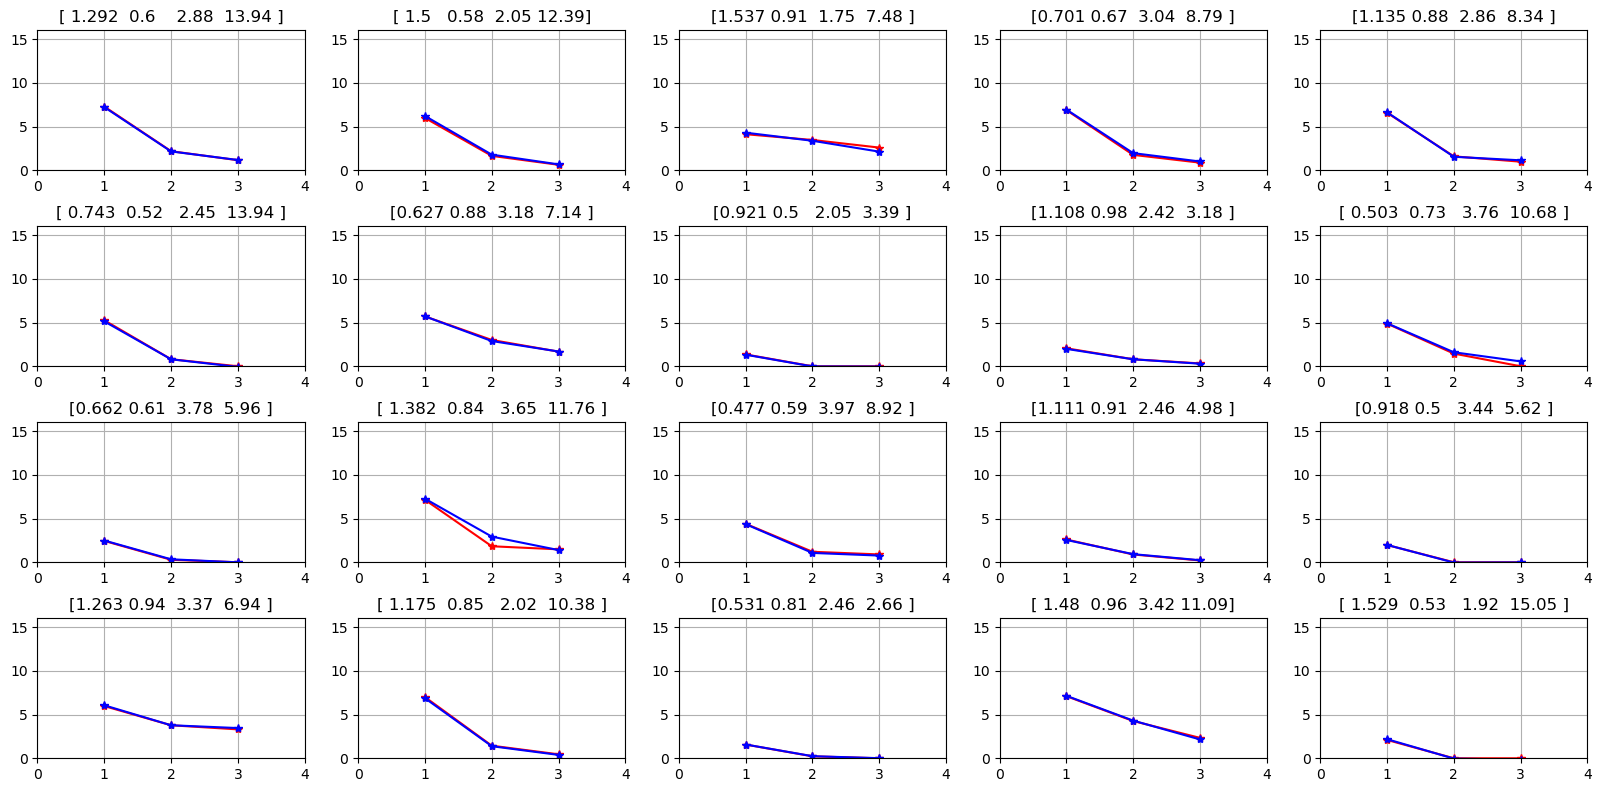

In [8]:
# load real part data (verify the model is working properly)
# [Wavelength, lattice, n_atom, n_substrate]


# plot 20 results from the test set
import matplotlib
import random
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

cases = 20
cols = 5
gs = gridspec.GridSpec(cases // cols + 1, cols)
gs.update(hspace=0.4)
fig1 = plt.figure(figsize = (20,12))
ax = []
test_number = []

model_loaded.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_loaded.to(device)

for i in range(cases):
    number = np.random.randint(0,xs1.shape[0])
    test_number.append(number)
    row = i//cols
    col = i % cols
    
    orig = ys1[number,:].to(device).cpu()
    pred = model_loaded(xs1[number,:].reshape(1,4096).to(device), x1s1[number,:].reshape(1,4).to(device)).cpu().detach().numpy()

    ax.append(fig1.add_subplot(gs[row,col]))
#     yticks = np.arange(-1,1.1,0.5)
#     ax[-1].set_yticks(yticks)
    ax[-1].set_ylim([0,16])
    ax[-1].set_xlim([0,4])

    xaxis = np.linspace(1,3,3)

    ax[-1].plot(xaxis,orig,"r*-")
    ax[-1].plot(xaxis,pred[0],"b*-")
    ax[-1].grid(True)
    ax[-1].set_title(x1s1[number,0:4].detach().cpu().numpy())


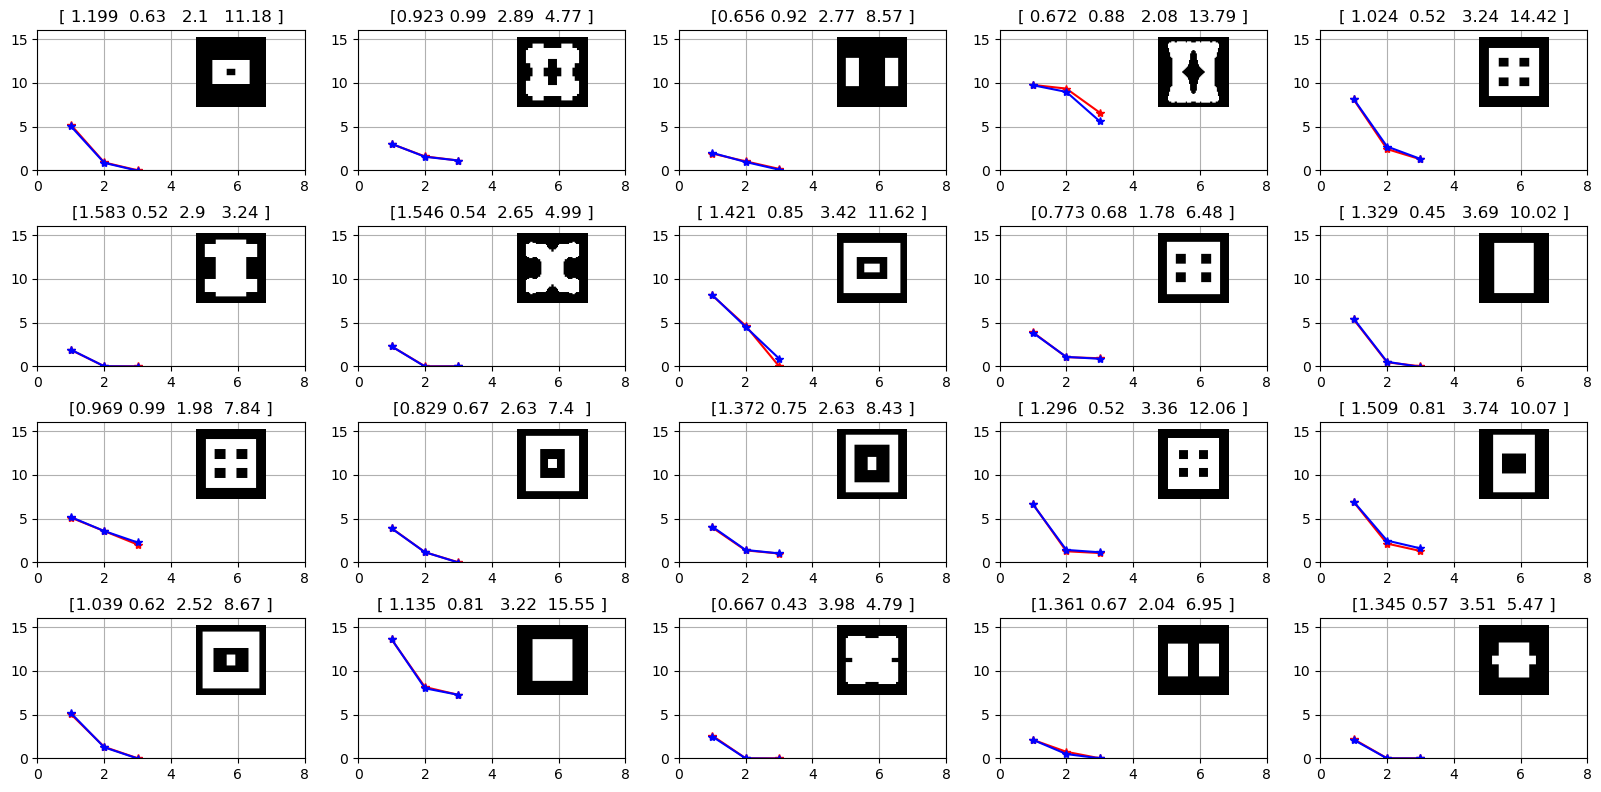

In [9]:
# plot results with 2D inset
# [Wavelength, lattice, n_atom, n_substrate]
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib
import random
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
cases = 20
cols = 5
gs = gridspec.GridSpec(cases // cols + 1, cols)
gs.update(hspace=0.4)
fig = plt.figure(figsize = (20,12))
ax = []
test_number = []

for i in range(cases):
    number = np.random.randint(0, xs1.shape[0])
    test_number.append(number)
    row = i // cols
    col = i % cols

    # Existing plotting code
    ax = fig.add_subplot(gs[row, col])
    orig = ys1[number,:].to(device).cpu()
    pred = model_loaded(xs1[number, :].reshape(1, 4096).to(device), x1s1[number, :].reshape(1, 4).to(device)).cpu().detach().numpy()

    # Set up the plot for original data and prediction
    ax.plot(xaxis, orig, "r*-")
    ax.plot(xaxis, pred[0], "b*-")
    ax.grid(True)
    ax.set_title(x1s1[number,0:4].detach().cpu().numpy())  # Your existing title setting code
    ax.set_ylim([0,16])
    ax.set_xlim([0,8])
    xaxis = np.linspace(1,3,3)

    # Create an inset axis for the image
    axins = inset_axes(ax, width="50%", height="50%", loc='upper right')
    img_data = xs1[number, :].cpu().numpy().reshape(64, 64)  # Reshape the tensor to 2D
    axins.imshow(img_data, cmap='gray')  # Display the image
    axins.axis('off')  # Turn off axis for inset


In [10]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def scale_pattern_in_binary_image(binary_image, scale_factor):
    # Convert the binary array to an image
    img = Image.fromarray(binary_image.astype('uint8') * 255)

    # Calculate new dimensions according to the scale factor
    new_size = (int(img.width * scale_factor), int(img.height * scale_factor))

    # Resize the image
    resized_img = img.resize(new_size, Image.NEAREST)

    # Create a new blank binary image of the original size
    new_binary_image = Image.new("L", (binary_image.shape[1], binary_image.shape[0]), 0)

    # Calculate the position to paste the resized image back into the center
    top_left_x = (new_binary_image.width - resized_img.width) // 2
    top_left_y = (new_binary_image.height - resized_img.height) // 2

    # Paste the resized image into the center of the blank image
    new_binary_image.paste(resized_img, (top_left_x, top_left_y))

    return np.array(new_binary_image) // 255


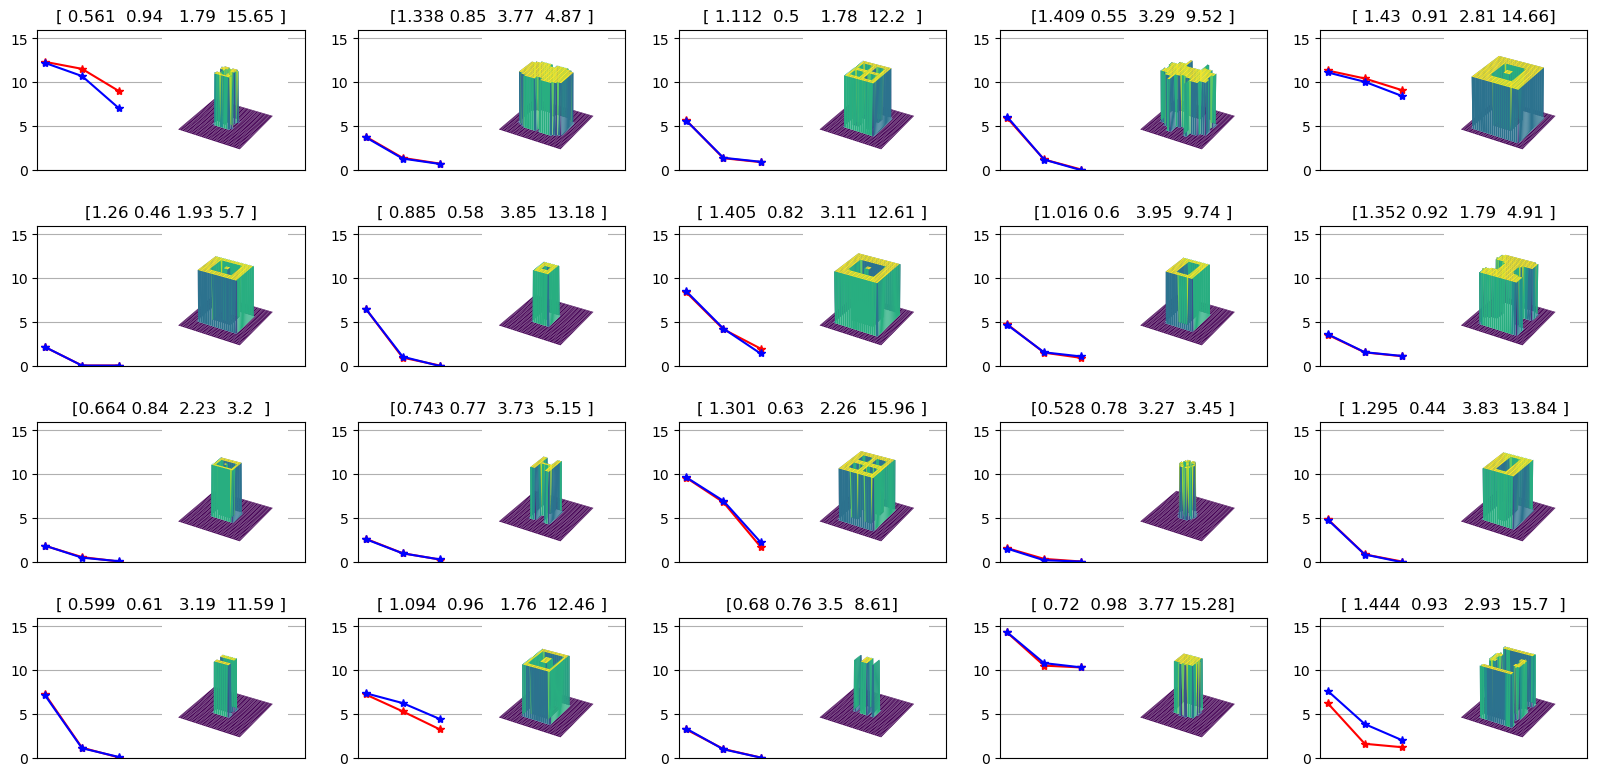

In [15]:
# plot results with 3D inset
# [Wavelength, lattice, n_atom, n_substrate]
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import random
import matplotlib.gridspec as gridspec

cases = 20
cols = 5
gs = gridspec.GridSpec(cases // cols + 1, cols)
gs.update(hspace=0.4)
fig = plt.figure(figsize = (20,12))
ax = []
test_number = []

for i in range(cases):
    number = np.random.randint(0, xs1.shape[0])
    test_number.append(number)
    row = i // cols
    col = i % cols

    # Existing plotting code
    ax = fig.add_subplot(gs[row, col])
    orig = ys1[number,:].to(device).cpu()
    pred = model_loaded(xs1[number, :].reshape(1, 4096).to(device), x1s1[number, :].reshape(1, 4).to(device)).cpu().detach().numpy()

    # Set up the plot for original data and prediction
    ax.plot(xaxis, orig, "r*-")
    ax.plot(xaxis, pred[0], "b*-")
    ax.grid(True)
    ax.set_xticks([])
    
    ax.set_title(x1s1[number,0:4].detach().cpu().numpy())  # Your existing title setting code
    ax.set_ylim([0,16])
    ax.set_xlim([0.8,8])
    xaxis = np.linspace(1,3,3)

    # Create a 3D inset for the image
    axins = inset_axes(ax, width="90%", height="90%", loc='center', 
                       bbox_to_anchor=(0.2, 0, 1, 1),  # x, y, width, height
                       bbox_transform=ax.transAxes, axes_class=Axes3D)
    img_data = xs1[number, :].cpu().numpy().reshape(64, 64)
    img_data = scale_pattern_in_binary_image(img_data, x1s1[number, 0]/1.6)
    X, Y = np.meshgrid(np.arange(img_data.shape[0]), np.arange(img_data.shape[1]))
    Z = img_data

    # Disable visibility of the axes
    axins._axis3don = False
    axins.plot_surface(X, Y, Z, cmap='viridis')
    axins.set_xticks([])
    axins.set_yticks([])
    axins.set_zticks([])
plt.show()

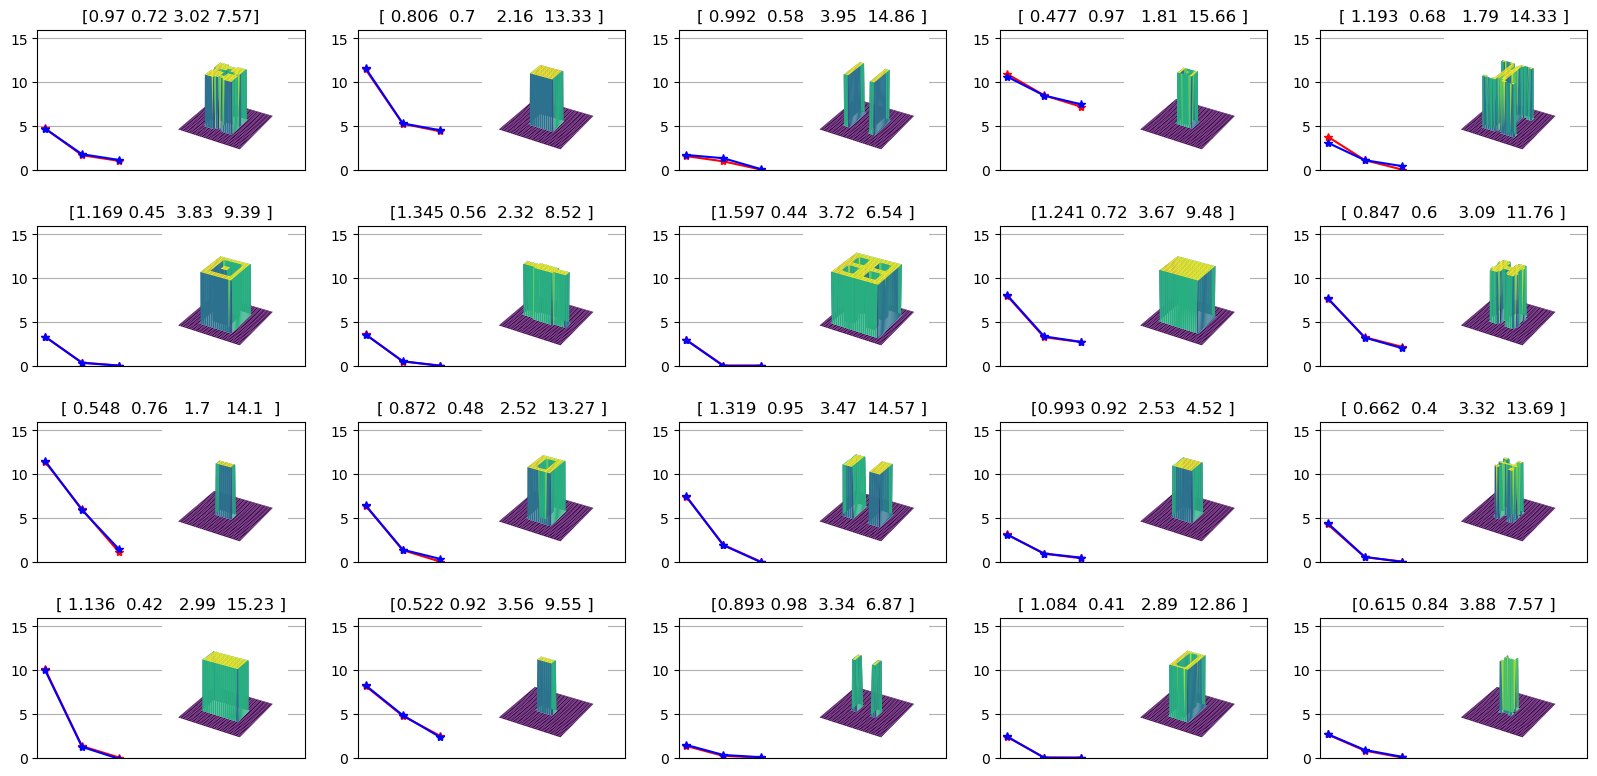

In [18]:
# plot results with 3D inset (train)
# [Wavelength, lattice, n_atom, n_substrate]
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import random
import matplotlib.gridspec as gridspec

cases = 20
cols = 5
gs = gridspec.GridSpec(cases // cols + 1, cols)
gs.update(hspace=0.4)
fig = plt.figure(figsize = (20,12))
ax = []
test_number = []

for i in range(cases):
    number = np.random.randint(0, xs.shape[0])
    test_number.append(number)
    row = i // cols
    col = i % cols

    # Existing plotting code
    ax = fig.add_subplot(gs[row, col])
    orig = ys[number,:].to(device).cpu()
    pred = model_loaded(xs[number, :].reshape(1, 4096).to(device), x1s[number, :].reshape(1, 4).to(device)).cpu().detach().numpy()

    # Set up the plot for original data and prediction
    ax.plot(xaxis, orig, "r*-")
    ax.plot(xaxis, pred[0], "b*-")
    ax.grid(True)
    ax.set_xticks([])
    
    ax.set_title(x1s[number,0:4].detach().cpu().numpy())  # Your existing title setting code
    ax.set_ylim([0,16])
    ax.set_xlim([0.8,8])
    xaxis = np.linspace(1,3,3)

    # Create a 3D inset for the image
    axins = inset_axes(ax, width="90%", height="90%", loc='center', 
                       bbox_to_anchor=(0.2, 0, 1, 1),  # x, y, width, height
                       bbox_transform=ax.transAxes, axes_class=Axes3D)
    img_data = xs[number, :].cpu().numpy().reshape(64, 64)
    img_data = scale_pattern_in_binary_image(img_data, x1s[number, 0]/1.6)
    X, Y = np.meshgrid(np.arange(img_data.shape[0]), np.arange(img_data.shape[1]))
    Z = img_data

    # Disable visibility of the axes
    axins._axis3don = False
    axins.plot_surface(X, Y, Z, cmap='viridis')
    axins.set_xticks([])
    axins.set_yticks([])
    axins.set_zticks([])
plt.show()

In [19]:
test_number

[602606,
 134767,
 679809,
 156869,
 949284,
 480906,
 842640,
 1019899,
 402229,
 224450,
 1072655,
 504738,
 608323,
 528478,
 1034584,
 484094,
 506476,
 17352,
 75245,
 204436]